In [ ]:
# prompt: install fb prophet

!pip install pystan==2.19.1.1
!pip install fbprophet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.2/16.2 MB 17.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pystan: filename=pystan-2.19.1.1-cp310-cp310-linux_x86_64.whl size=61975127 sha256=18419ce46005ba00ae436a877032c0c45c69d886d5ef7c7e3457b08d11e82be6
  Stored in directory: /root/.cache/pip/wheels/3d/1c/94/4516243362eedbedad15ac4389691ee3bf2d45bec2639c9d8b
Successfully built pystan
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.0/64.0 kB 964.9 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 21.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 65.1 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originate

In [ ]:
pip install prophet --no-binary :all:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.metrics import mean_squared_error
from math import sqrt


In [2]:
# Load data from CSV
df = pd.read_csv("Accounts_Payable_Transactions.csv")

In [3]:
df.head()

,Date,CheckNum,VendorName,Amount,Description,AccountNumber,InvoiceNumber,AcctPerYr,AcctPerMo
0,08/25/2014,9999998,MISCELLANEOUS VENDOR CX,1373.43,LID-560 POCKET READER 4 A,101-2106-802.81-36,544,2015,2
1,07/09/2020,373810,THE WHARF,134.80,SAFETY BOOTS,101-5701-805.81-05,86037,2019,7
2,07/22/2020,374297,E RECYCLING OF CALIFORNIA,-529.54,E WASTE,631-6301-842.82-09,87656,2020,8
3,06/25/2020,373524,MOTOR VEHICLE NETWORK,600.00,BEVERAGE CONT RECYCLING,631-6828-823.82-09,20-36202,2020,9
4,06/18/2020,373208,HARRIS WATER CONDITIONING,40.00,ENGINEERING WATER,101-3201-803.81-02,47638,2020,9


In [6]:
# Data preprocessing
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.dropna(subset=['Date', 'Amount'])
df = df.groupby('Date')['Amount'].sum().reset_index()


In [33]:
df.head()

,Date,Amount
0,2009-04-28,-175.00
1,2009-06-02,-39.93
2,2010-01-19,-10.00
3,2010-03-16,-44.58
4,2010-05-18,-10.00


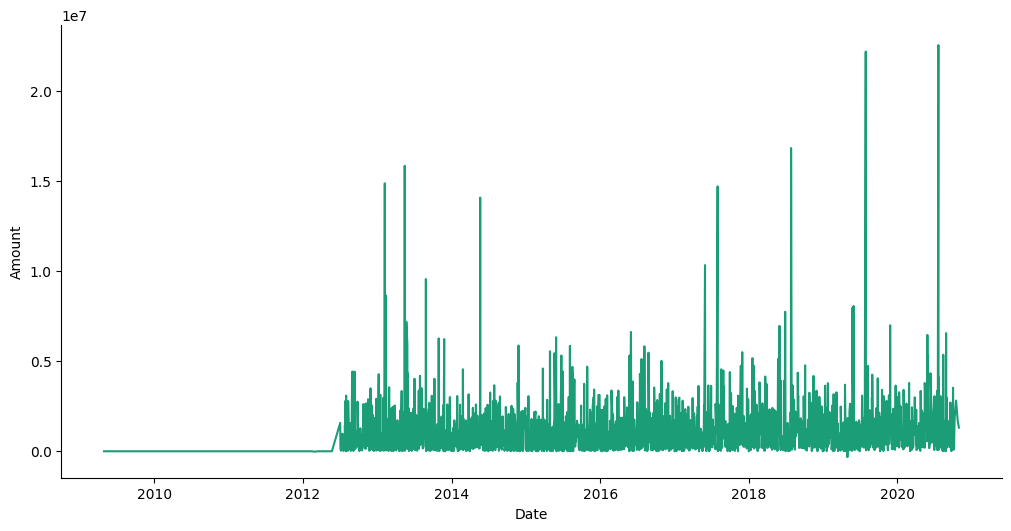

In [32]:
# @title Date vs Amount

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Date']
  ys = series['Amount']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('Date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date')
_ = plt.ylabel('Amount')

In [4]:
# Analyze time series
def analyze_time_series(df):
    decomposition = seasonal_decompose(df.set_index('Date'), model='additive', period=12)
    decomposition.plot()
    plt.show()
    result = adfuller(df['Amount'])
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    if result[1] <= 0.05:
        print('Stationary')
    else:
        print('Non-stationary')


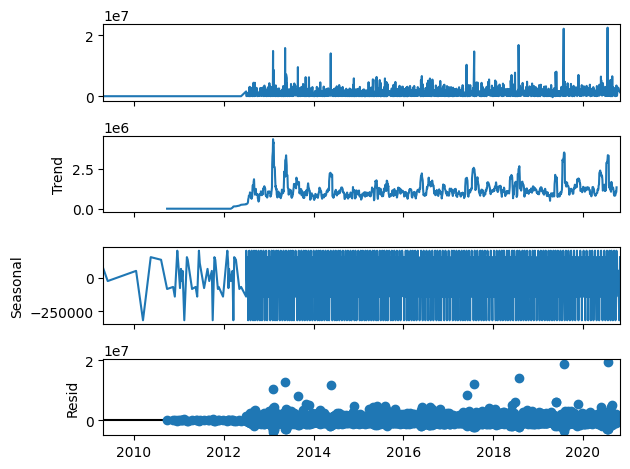

ADF Statistic: -7.967050755168842
p-value: 2.846440640523167e-12
Stationary


In [7]:
analyze_time_series(df)

In [8]:
# Split data into train and test sets
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]


In [14]:
train.head()


,Date,Amount
0,2009-04-28,-175.00
1,2009-06-02,-39.93
2,2010-01-19,-10.00
3,2010-03-16,-44.58
4,2010-05-18,-10.00


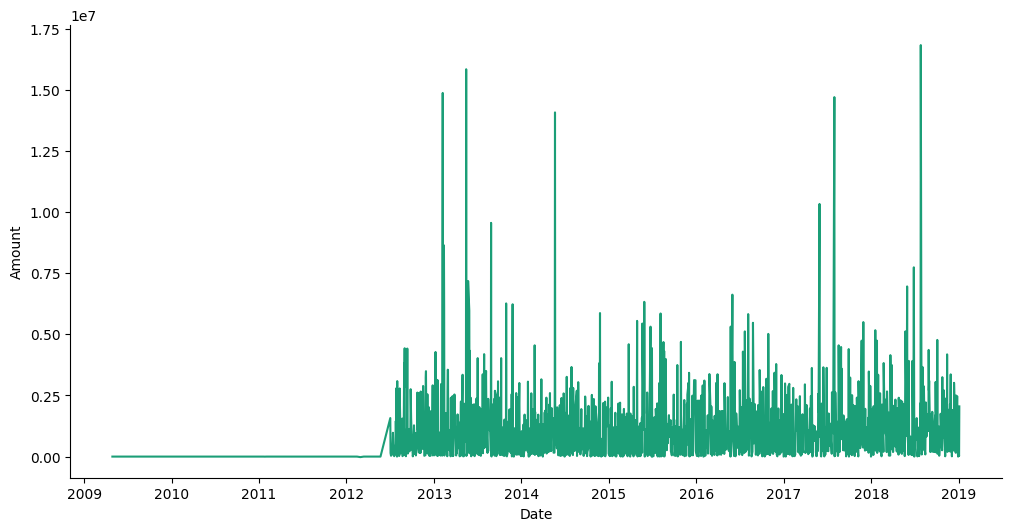

In [15]:
# @title Date vs Amount

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Date']
  ys = series['Amount']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = train.sort_values('Date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date')
_ = plt.ylabel('Amount')

<Axes: xlabel='Date'>

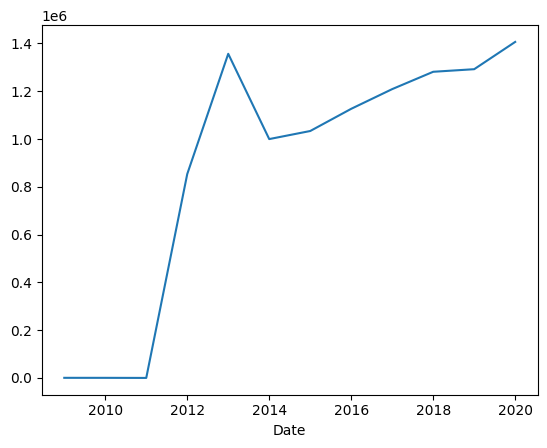

In [ ]:
# @title Amount by Year

df.groupby(df['Date'].dt.year)['Amount'].mean().plot()

In [16]:
test.head()

,Date,Amount
1415,2019-01-07,599497.86
1416,2019-01-08,480234.19
1417,2019-01-09,287283.03
1418,2019-01-10,3640242.59
1419,2019-01-14,569710.80


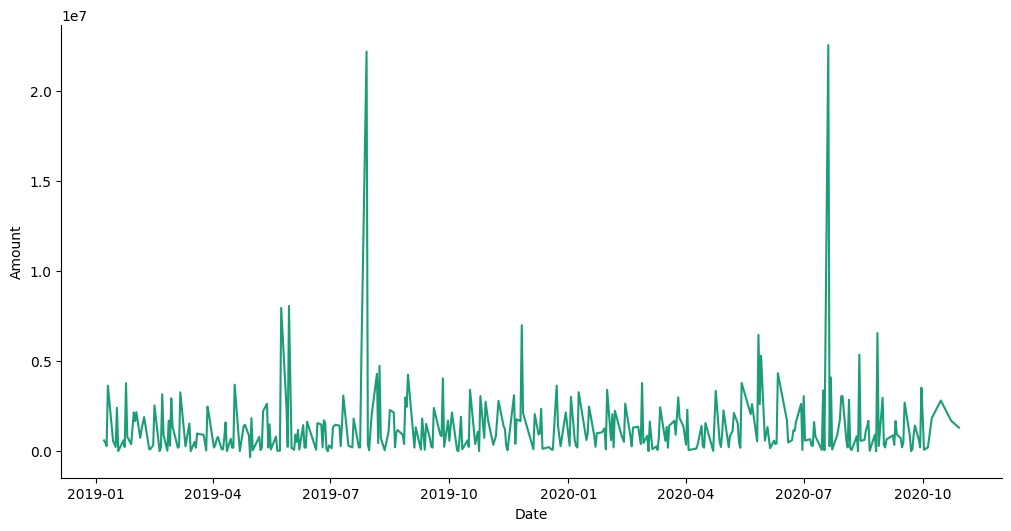

In [17]:
# @title Date vs Amount

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Date']
  ys = series['Amount']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = test.sort_values('Date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date')
_ = plt.ylabel('Amount')

In [9]:
# Prophet model
def prophet_model(df):
    df_prophet = df.rename(columns={'Date': 'ds', 'Amount': 'y'})
    model = Prophet()
    model.fit(df_prophet)
    future = model.make_future_dataframe(periods=365)
    forecast = model.predict(future)
    fig = model.plot(forecast)
    plt.show()
    forecast = forecast[['ds', 'yhat']].tail(len(test))
    forecast = forecast.set_index('ds')
    error = mean_squared_error(test['Amount'], forecast['yhat'])
   # print(test['Date'],test['Amount'], forecast['yhat'])
    print('Prophet RMSE:', sqrt(error))
    plt.plot(test['Date'], test['Amount'], label='Actual')
    plt.plot(test['Date'], forecast['yhat'], color='red', label='Predicted')
    plt.legend()
    plt.show()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx8il_vhm/cm2sghc9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx8il_vhm/guh7tk4u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74131', 'data', 'file=/tmp/tmpx8il_vhm/cm2sghc9.json', 'init=/tmp/tmpx8il_vhm/guh7tk4u.json', 'output', 'file=/tmp/tmpx8il_vhm/prophet_model7spw2192/prophet_model-20240314201747.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:17:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:17:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


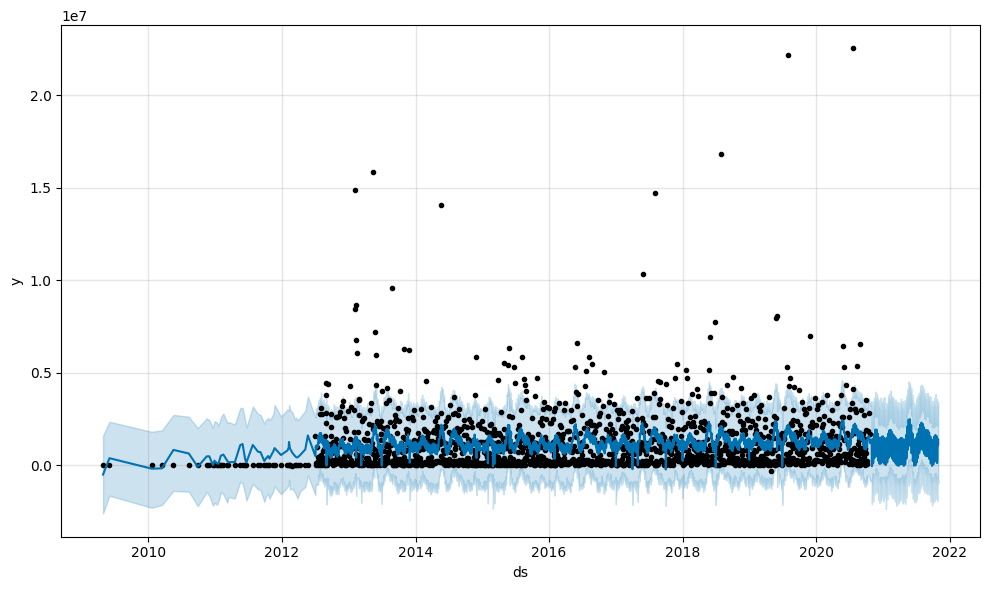

Prophet RMSE: 2130098.6812017406


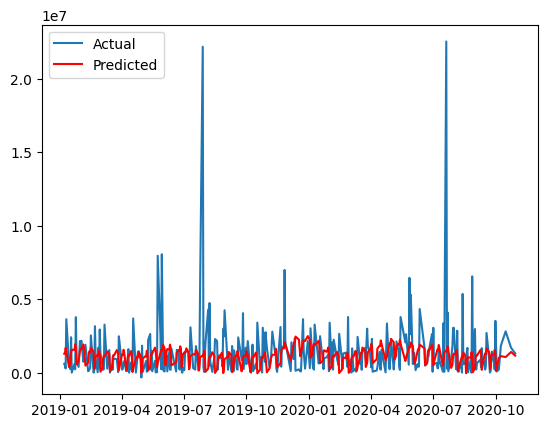

In [10]:
prophet_model(df)

In [11]:
d_prophet = df.rename(columns={'Date': 'ds', 'Amount': 'y'})
model1 = Prophet()
model1.fit(d_prophet)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx8il_vhm/xncm6mp3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx8il_vhm/1doxblga.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88624', 'data', 'file=/tmp/tmpx8il_vhm/xncm6mp3.json', 'init=/tmp/tmpx8il_vhm/1doxblga.json', 'output', 'file=/tmp/tmpx8il_vhm/prophet_modelx8qw60s6/prophet_model-20240314201752.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:17:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:17:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [14]:
df_cv = cross_validation(model1, initial='730 days', period='180 days', horizon = '365 days')


INFO:prophet:Making 18 forecasts with cutoffs between 2011-06-14 00:00:00 and 2019-10-30 00:00:00


  0%|          | 0/18 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 16.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx8il_vhm/yexwrhhw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx8il_vhm/32qsh9ju.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98011', 'data', 'file=/tmp/tmpx8il_vhm/yexwrhhw.json', 'init=/tmp/tmpx8il_vhm/32qsh9ju.json', 'output', 'file=/tmp/tmpx8il_vhm/prophet_model51n9iazp/prophet_model-20240314201806.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
20:18:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:18:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:n_changepoints greater than number of observations. Using 24.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpx8il_vhm/zqxuhk9w.json
DEBUG:cmdstanpy:input tempfi

In [13]:
from prophet.diagnostics import cross_validation

In [23]:
import prophet
prophet.__version__

'1.1.5'

In [15]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2011-06-21,18613.811931,18557.741231,18672.396493,-600.00,2011-06-14
1,2011-07-26,-30165.838116,-30225.914257,-30110.128576,-600.00,2011-06-14
2,2011-08-23,-99438.129547,-99496.977438,-99381.536528,-677.90,2011-06-14
3,2011-09-06,14273.631549,14215.057515,14336.424086,-294.22,2011-06-14
4,2011-09-27,16056.352483,15998.991959,16116.437753,-600.00,2011-06-14


In [16]:
!pip install seaborn
import seaborn as sns

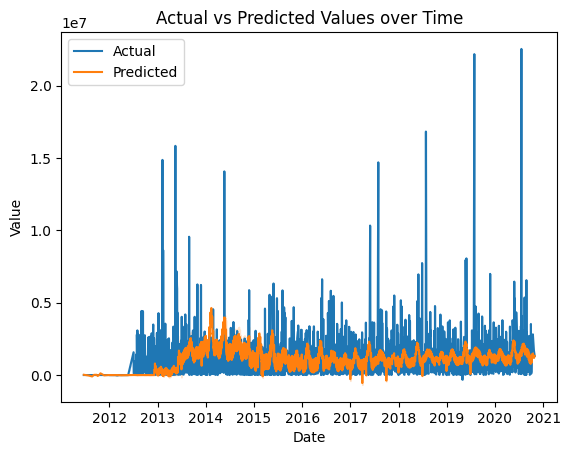

In [17]:
# @title Actual vs Predicted Values over Time


import matplotlib.pyplot as plt
sns.lineplot(data=df_cv, x="ds", y="y", label="Actual")
sns.lineplot(data=df_cv, x="ds", y="yhat", label="Predicted")
plt.xlabel("Date")
plt.ylabel("Value")
_ = plt.title("Actual vs Predicted Values over Time")

In [19]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

INFO:prophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,mdape,smape,coverage
0,40 days,2.066247e+12,1.437445e+06,1.026726e+06,0.901092,1.008158,0.860058
1,41 days,2.060010e+12,1.435274e+06,1.019854e+06,0.901092,1.013134,0.853741
2,42 days,2.050008e+12,1.431785e+06,1.013610e+06,0.933096,1.027544,0.851312
3,43 days,2.066374e+12,1.437489e+06,1.019923e+06,0.956872,1.037251,0.850340
4,44 days,2.040091e+12,1.428318e+06,1.014398e+06,0.960586,1.039423,0.849611


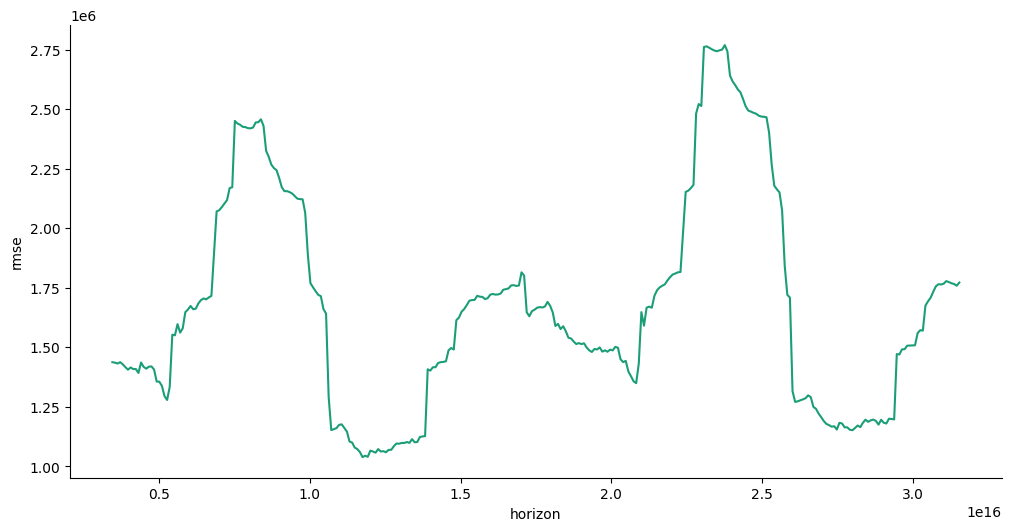

In [20]:
# @title horizon vs rmse

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['horizon']
  ys = series['rmse']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_p.sort_values('horizon', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('horizon')
_ = plt.ylabel('rmse')

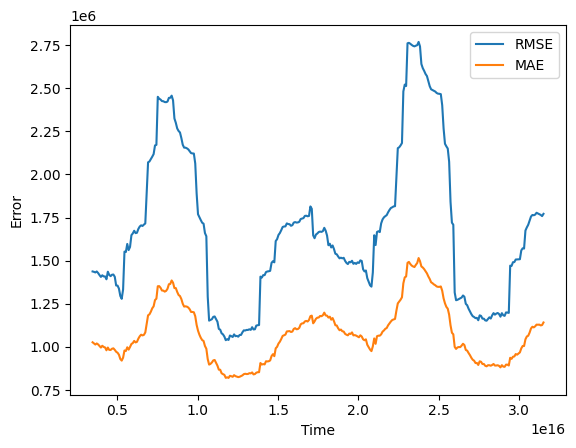

In [65]:
# @title RMSE vs MAE over time

import matplotlib.pyplot as plt
plt.plot(df_p['horizon'], df_p['rmse'], label='RMSE')
plt.plot(df_p['horizon'], df_p['mae'], label='MAE')
plt.xlabel('Time')
plt.ylabel('Error')
_ = plt.legend()